In [2]:
print("Hello, World!")
#source .venv/bin/activate


Hello, World!


Loading CT pig data 

In [3]:
from pathlib import Path
import pydicom
import matplotlib.pyplot as plt

# Ret kun denne sti hvis nødvendigt
DICOM_DIR = Path(
    "/Users/sofiehultengren/Desktop/Kandidat speciale /CT data/Gris 1401-2025/"
    "Baseline/DICOM/00000F62/AA15D35E/AA12AD7C/Baseline CFA 1/80%"
)


In [4]:
dicom_files = sorted(DICOM_DIR.glob("*"))

print(f"Fandt {len(dicom_files)} filer")
print("Første fil:", dicom_files[0])


Fandt 1 filer
Første fil: /Users/sofiehultengren/Desktop/Kandidat speciale /CT data/Gris 1401-2025/Baseline/DICOM/00000F62/AA15D35E/AA12AD7C/Baseline CFA 1/80%/EE0EE68D


Shape: (160, 512, 512)


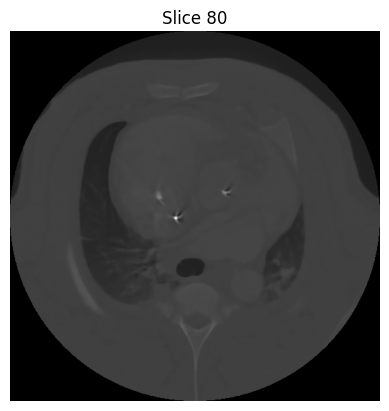

In [5]:
ds = pydicom.dcmread(dicom_files[0])
img = ds.pixel_array   # (160, 512, 512)

print("Shape:", img.shape)

# vis midterste slice
i = img.shape[0] // 2
plt.imshow(img[i], cmap="gray")
plt.title(f"Slice {i}")
plt.axis("off")
plt.show()


In [6]:
import pydicom
import matplotlib.pyplot as plt
from ipywidgets import interact

ds = pydicom.dcmread(dicom_files[0])
img = ds.pixel_array   # (n_slices, H, W)

def show_slice(i):
    plt.figure(figsize=(5,5))
    plt.imshow(img[i], cmap="gray", vmin=-160, vmax=240)
    plt.title(f"Slice {i+1}/{img.shape[0]}")
    plt.axis("off")
    plt.show()




interact(show_slice, i=(0, img.shape[0]-1))


interactive(children=(IntSlider(value=79, description='i', max=159), Output()), _dom_classes=('widget-interact…

<function __main__.show_slice(i)>

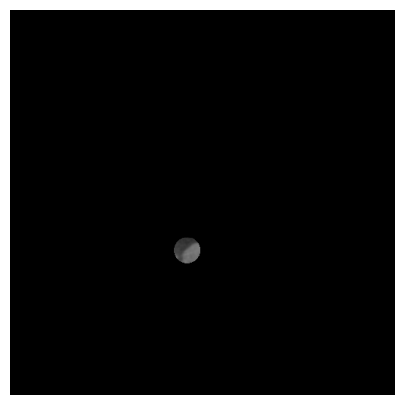

interactive(children=(IntSlider(value=0, description='i', max=159), Output()), _dom_classes=('widget-interact'…

<function __main__.update(i)>

In [7]:
import pydicom
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact

ds = pydicom.dcmread(dicom_files[0])
img = ds.pixel_array

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(img[0], cmap="gray", vmin=-200, vmax=800)
ax.axis("off")

def update(i):
    im.set_data(img[i])
    ax.set_title(f"Slice {i+1}/{img.shape[0]}")
    fig.canvas.draw_idle()

slider = IntSlider(min=0, max=img.shape[0]-1, step=1, value=0)
interact(update, i=slider)


In [8]:
import pydicom, numpy as np

ds = pydicom.dcmread(dicom_files[0])
vol = ds.pixel_array.astype(np.float32)

# CT til HU (hvis tags findes)
slope = float(getattr(ds, "RescaleSlope", 1.0))
intercept = float(getattr(ds, "RescaleIntercept", 0.0))
vol = vol * slope + intercept

# Spacing (mm): (row, col) og slice spacing
ps = getattr(ds, "PixelSpacing", [1.0, 1.0])
dz = float(getattr(ds, "SliceThickness", 1.0))  # nogle gange SpacingBetweenSlices
dy, dx = float(ps[0]), float(ps[1])

voxel_volume_mm3 = dx * dy * dz
print("vol shape (z,y,x):", vol.shape)
print("voxel (mm):", (dz, dy, dx), " voxel mm3:", voxel_volume_mm3)


vol shape (z,y,x): (160, 512, 512)
voxel (mm): (1.0, 1.0, 1.0)  voxel mm3: 1.0


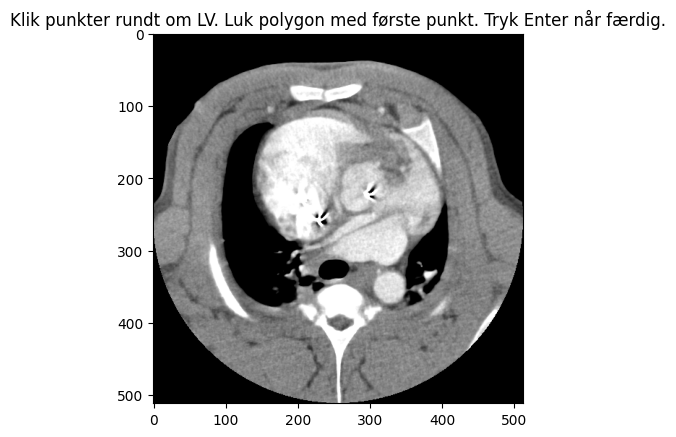

ROI pixels: 0


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import PolygonSelector
from matplotlib.path import Path

# vol: (z,y,x) fx HU-volumen
z = vol.shape[0] // 2
img2d = vol[z]

roi_mask2d = np.zeros(img2d.shape, dtype=bool)

fig, ax = plt.subplots()
ax.imshow(img2d, cmap="gray", vmin=-160, vmax=240)
ax.set_title("Klik punkter rundt om LV. Luk polygon med første punkt. Tryk Enter når færdig.")

def onselect(verts):
    global roi_mask2d
    h, w = img2d.shape
    yx = np.mgrid[:h, :w].transpose(1,2,0).reshape(-1,2)  # (y,x)
    p = Path(verts)
    roi_mask2d = p.contains_points(yx).reshape(h, w)
    plt.close(fig)

poly = PolygonSelector(ax, onselect)
plt.show()

# roi_mask2d er nu din ROI maske for slice z
print("ROI pixels:", roi_mask2d.sum())


In [ ]:
het